In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from typing import Dict, Any
from collections import Counter

import numpy as np
import pandas as pd
import sklearn as sk
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, 
    average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer
)
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import dvu  # for visualization

import imodels

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')

from experiments.config.config_general import DATASETS
from experiments.models.stablelinear import StableLinearClassifier
from experiments.models.stableskope import StableSkopeClassifier
from experiments.notebooks import viz
from experiments.util import get_comparison_result, get_clean_dataset, get_best_model_under_complexity, MODEL_COMPARISON_PATH

np.random.seed(0)

/accounts/projects/binyu/keyan3/imodels/experiments/notebooks


# dataset stats

In [2]:
metadata = []
columns = ['name', 'samples', 'orig_features', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
orig_features = [9, 20, 3, 13, 10, 23, 91, 36]
for i, (dataset_name, path) in enumerate(DATASETS):
    X, y, feature_names = get_clean_dataset(path=path)
    shape = X.shape
    class_counts = np.unique(y, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], orig_features[i], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name')

,samples,orig_features,features,class 0 ct,class 1 ct,majority class %
name,,,,,,
recidivism,6172,9,21,3182,2990,0.515554
credit,30000,20,24,23364,6636,0.778800
juvenile,3640,3,286,3153,487,0.866209
readmission,101763,13,150,54861,46902,0.539106
breast-cancer,277,10,17,196,81,0.707581
credit-g,1000,23,61,300,700,0.700000
haberman,306,91,3,81,225,0.735294
heart,270,36,15,150,120,0.555556


- Recreate original background gradient analysis from cache 

# complexity vs. test performance plots

In [3]:
baselines = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit',
    'brs',
    'brl'
]

## readmission

In [4]:
metric = 'mean_avg_precision'
ensembles = [
#     'stbl_l2_mm0',
#     'stbl_l2_mm1',
    'stbl_l1_mm0',
#     'stbl_l1_mm1',
    'stbl_l1_mm2'
]
test_models = baselines + ensembles

In [5]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='readmission',
                          prefix='test') for mname in test_models
]

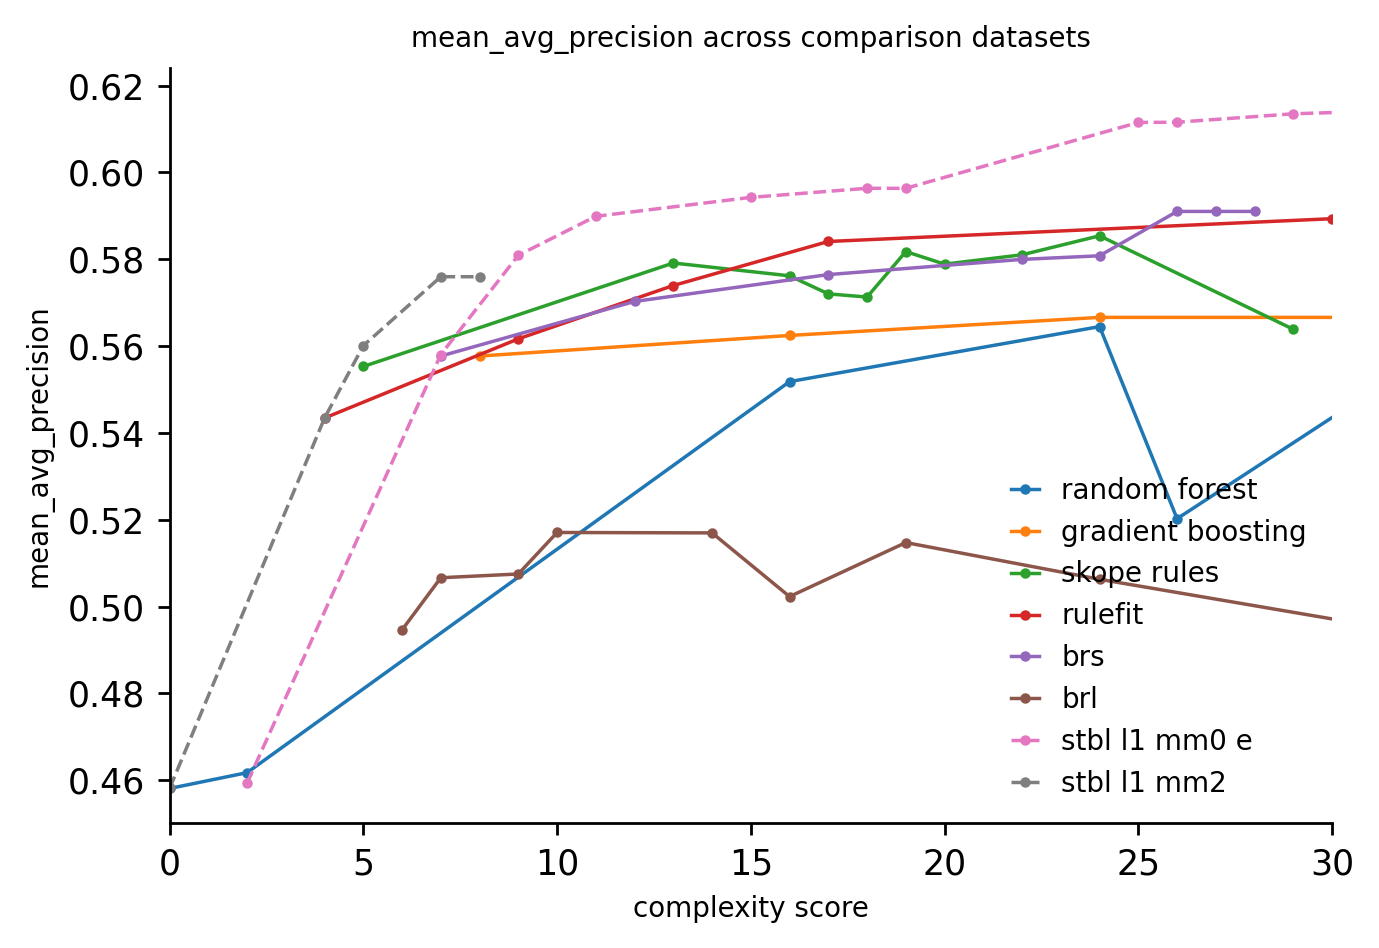

In [6]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## credit

In [7]:
metric = 'mean_avg_precision'
ensembles = [
#     'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [8]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='credit',
                          prefix='test') for mname in test_models
]

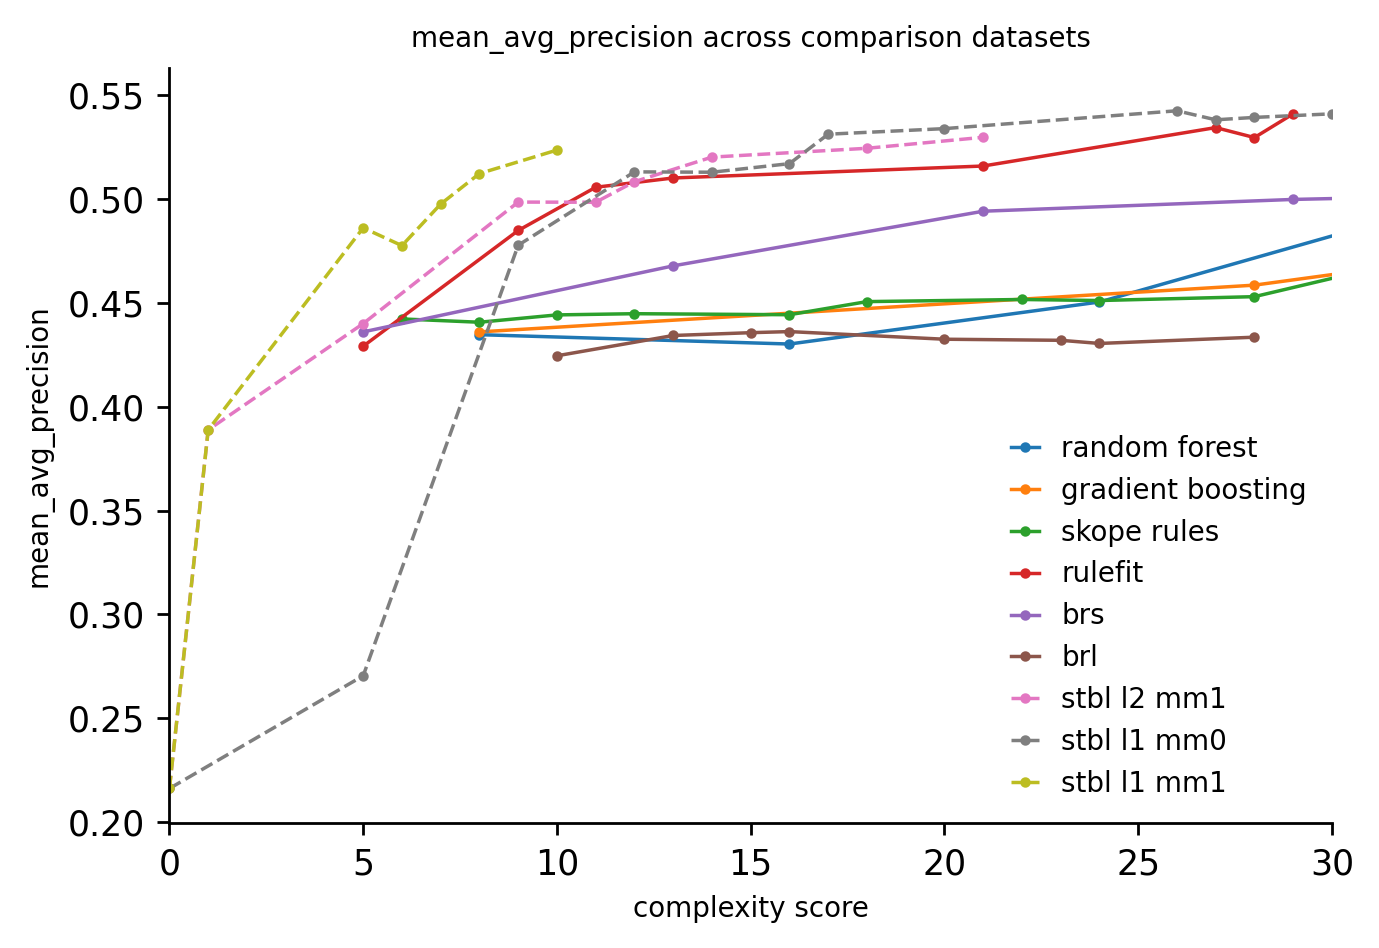

In [9]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## recidivism

In [10]:
metric = 'mean_avg_precision'
ensembles = [
#     'stbl_l2_mm0',
#     'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1',
    'stbl_l1_mm2'
]
test_models = baselines + ensembles 

In [11]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='recidivism',
                          prefix='test') for mname in test_models
]

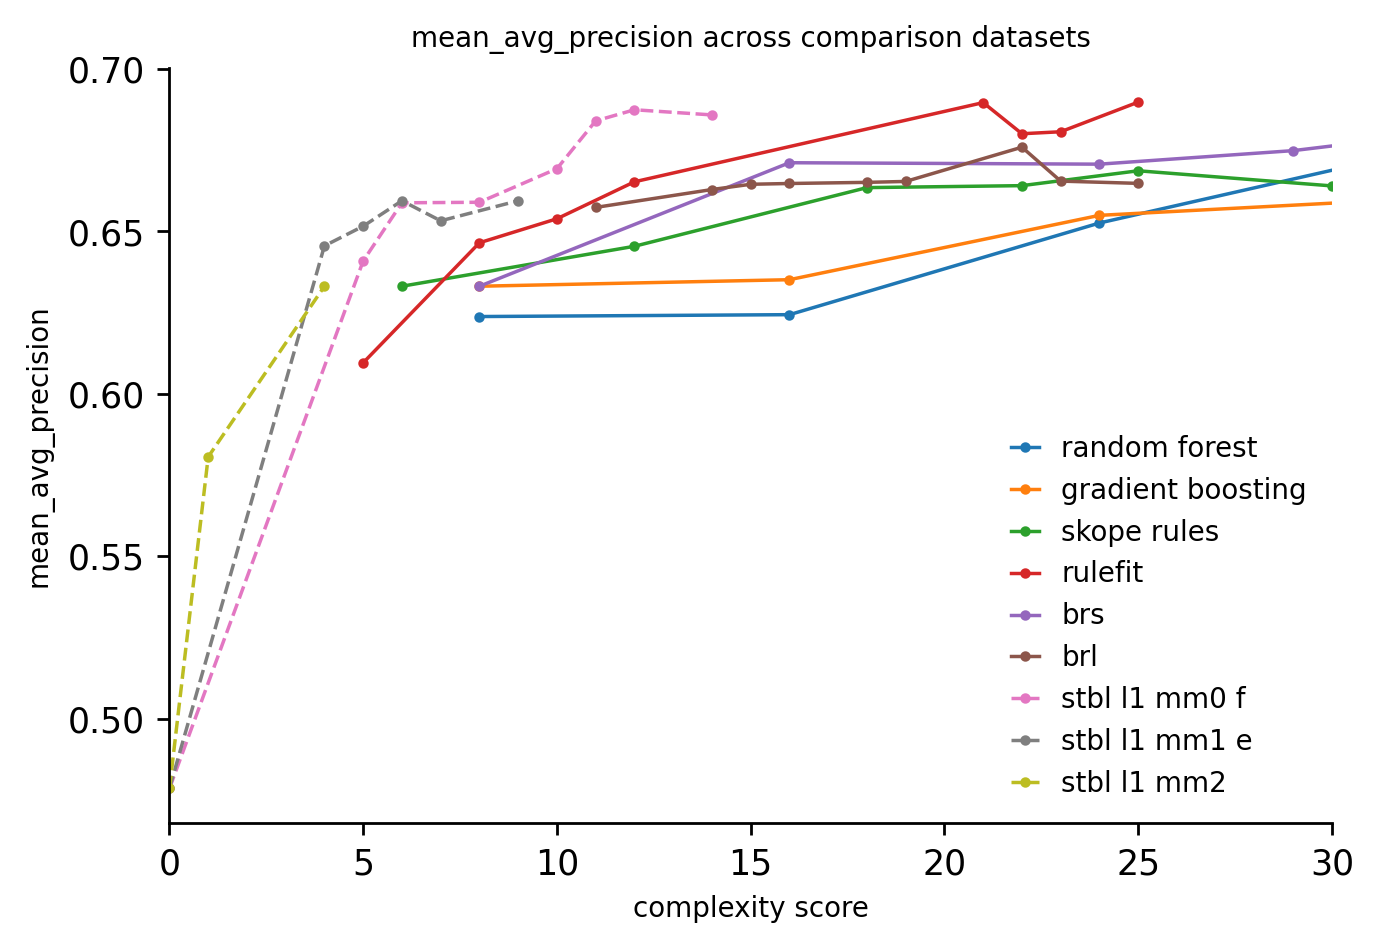

In [12]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## juvenile

In [13]:
metric = 'mean_avg_precision'
ensembles = [
#     'stbl_l2_mm0',
    'stbl_l2_mm1',
#     'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [14]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='juvenile',
                          prefix='test') for mname in test_models
]

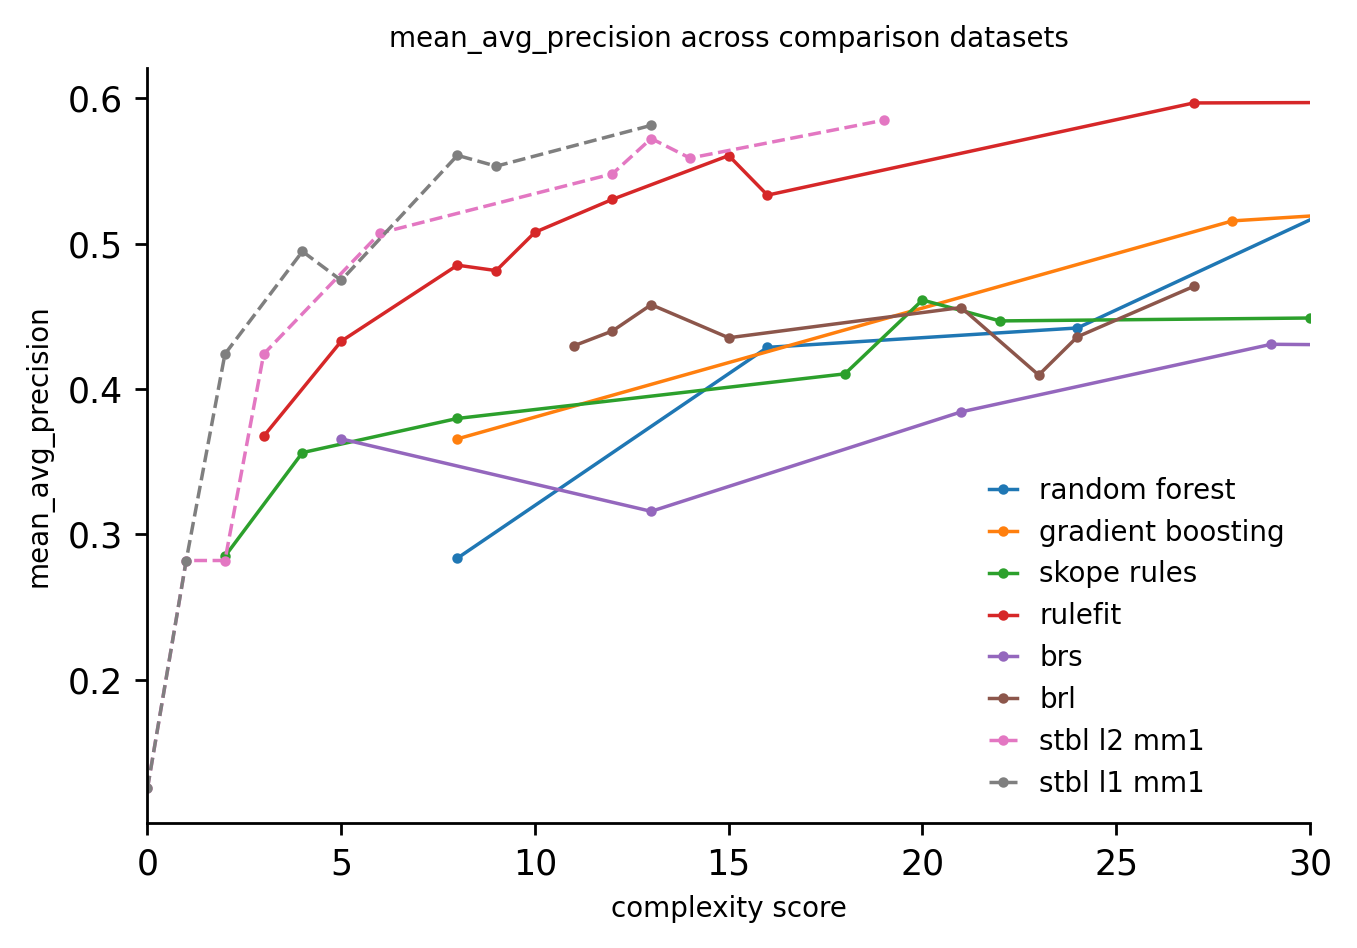

In [15]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

# best metric under limit

In [16]:
from collections import defaultdict
def best_metric_under_limit(c, models, datasets, metric, low_data=False):
    acc_dict = defaultdict(lambda:[])
    for dataset in datasets:
        for model in models:
            result_df = get_comparison_result(MODEL_COMPARISON_PATH, model, dataset, 'test', low_data)['df']
            result_df_under_c = result_df[result_df['mean_complexity'] < c]
            acc_dict[dataset].append(result_df_under_c[f'mean_{metric}'].max())
    return pd.DataFrame(acc_dict, index=models)

In [17]:
ensembles = [
#     'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1'
]
datasets = ['recidivism', 'readmission', 'credit', 'juvenile']

acc_df = best_metric_under_limit(15, baselines + ensembles, datasets, 'best_accuracy')
# acc_df.style.background_gradient()
acc_df.style.highlight_max()

,recidivism,readmission,credit,juvenile
random_forest,0.665587,0.541886,0.829833,0.875000
gradient_boosting,0.649393,0.615438,0.829500,0.875000
skope_rules,0.655870,0.618975,0.830333,0.899725
rulefit,0.670445,0.616961,0.829500,0.896978
brs,0.649393,0.619859,0.829500,0.875000
brl,0.667206,0.576082,0.809667,0.898352
stbl_l2_mm1,0.663968,0.615487,0.829667,0.906593
stbl_l1_mm0,0.681781,0.619859,0.830667,0.899725
stbl_l1_mm1,0.662348,0.621628,0.830167,0.905220


In [18]:
pr_df = best_metric_under_limit(15, baselines + ensembles, datasets, 'avg_precision')
# pr_df.style.background_gradient()
pr_df.style.highlight_max()

,recidivism,readmission,credit,juvenile
random_forest,0.623816,0.461760,0.434717,0.283527
gradient_boosting,0.633144,0.557700,0.436057,0.365590
skope_rules,0.645444,0.579124,0.444819,0.379648
rulefit,0.665293,0.573944,0.510176,0.530424
brs,0.633144,0.570271,0.467858,0.365590
brl,0.662913,0.517070,0.434322,0.457941
stbl_l2_mm1,0.662159,0.563839,0.520231,0.572287
stbl_l1_mm0,0.687466,0.589881,0.513125,0.527428
stbl_l1_mm1,0.659460,0.595212,0.523614,0.581355


In [19]:
roc_df = best_metric_under_limit(15, baselines + ensembles, datasets, 'rocauc')
# roc_df.style.background_gradient()
roc_df.style.highlight_max()

,recidivism,readmission,credit,juvenile
random_forest,0.685818,0.507283,0.692291,0.744458
gradient_boosting,0.691278,0.629353,0.694629,0.805579
skope_rules,0.705797,0.642448,0.695357,0.689090
rulefit,0.721489,0.639104,0.753825,0.862473
brs,0.691278,0.636796,0.736012,0.820303
brl,0.714446,0.573176,0.715806,0.827781
stbl_l2_mm1,0.707189,0.630727,0.745093,0.867614
stbl_l1_mm0,0.726954,0.645161,0.741724,0.864777
stbl_l1_mm1,0.712969,0.648761,0.744134,0.876809


# low data

## readmission

In [20]:
metric = 'mean_avg_precision'
ensembles = [
    'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1',
    'stbl_l1_mm2'
]
test_models = baselines + ensembles

In [21]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='readmission',
                          prefix='test',
                          low_data=True) for mname in test_models
]

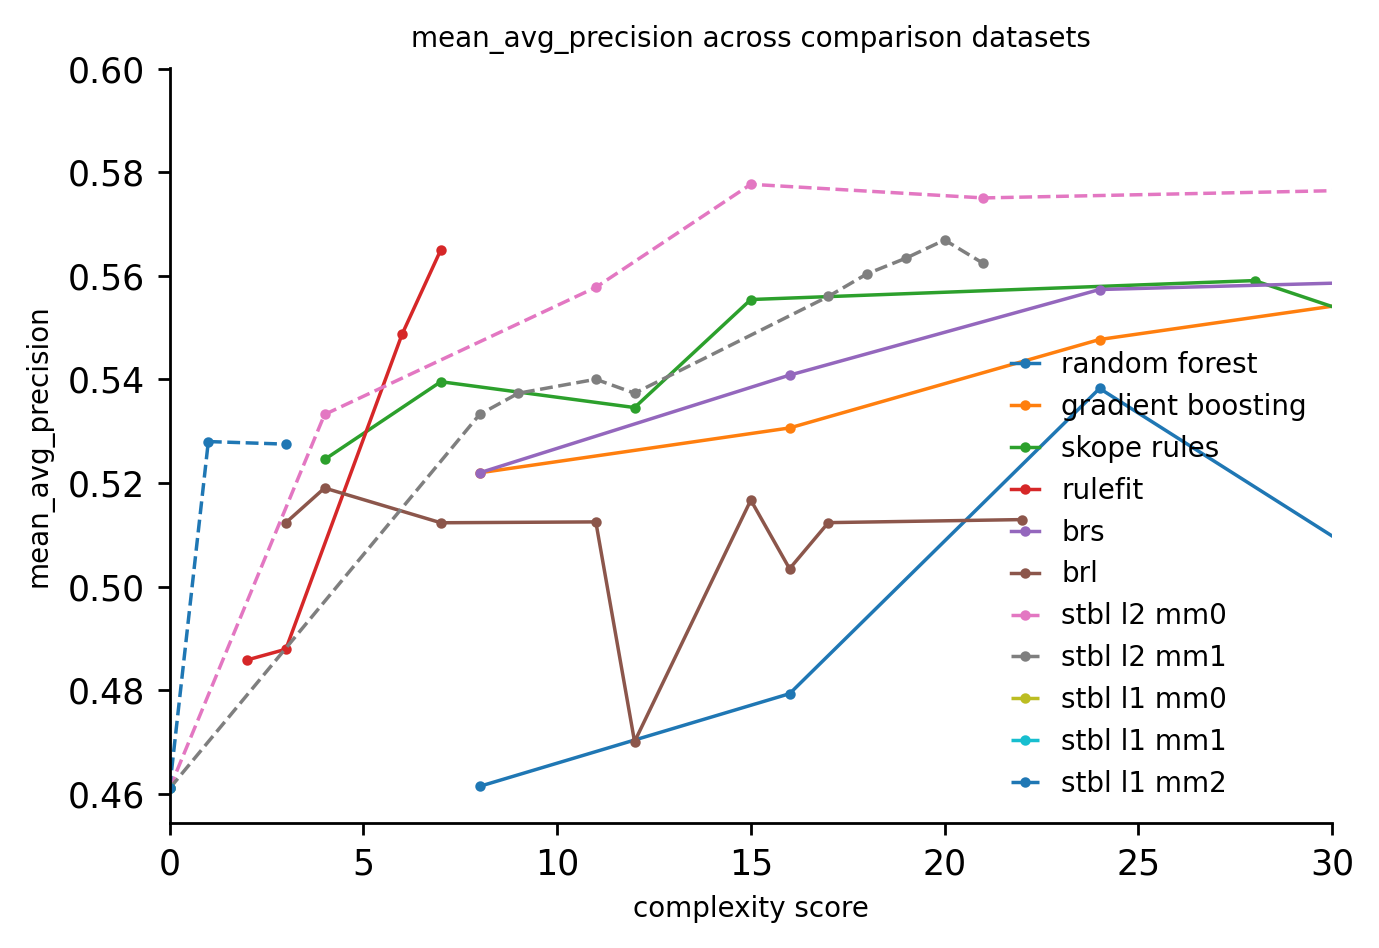

In [22]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## credit

In [23]:
metric = 'mean_avg_precision'
ensembles = [
    'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [24]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='credit',
                          prefix='test',
                          low_data=True) for mname in test_models
]

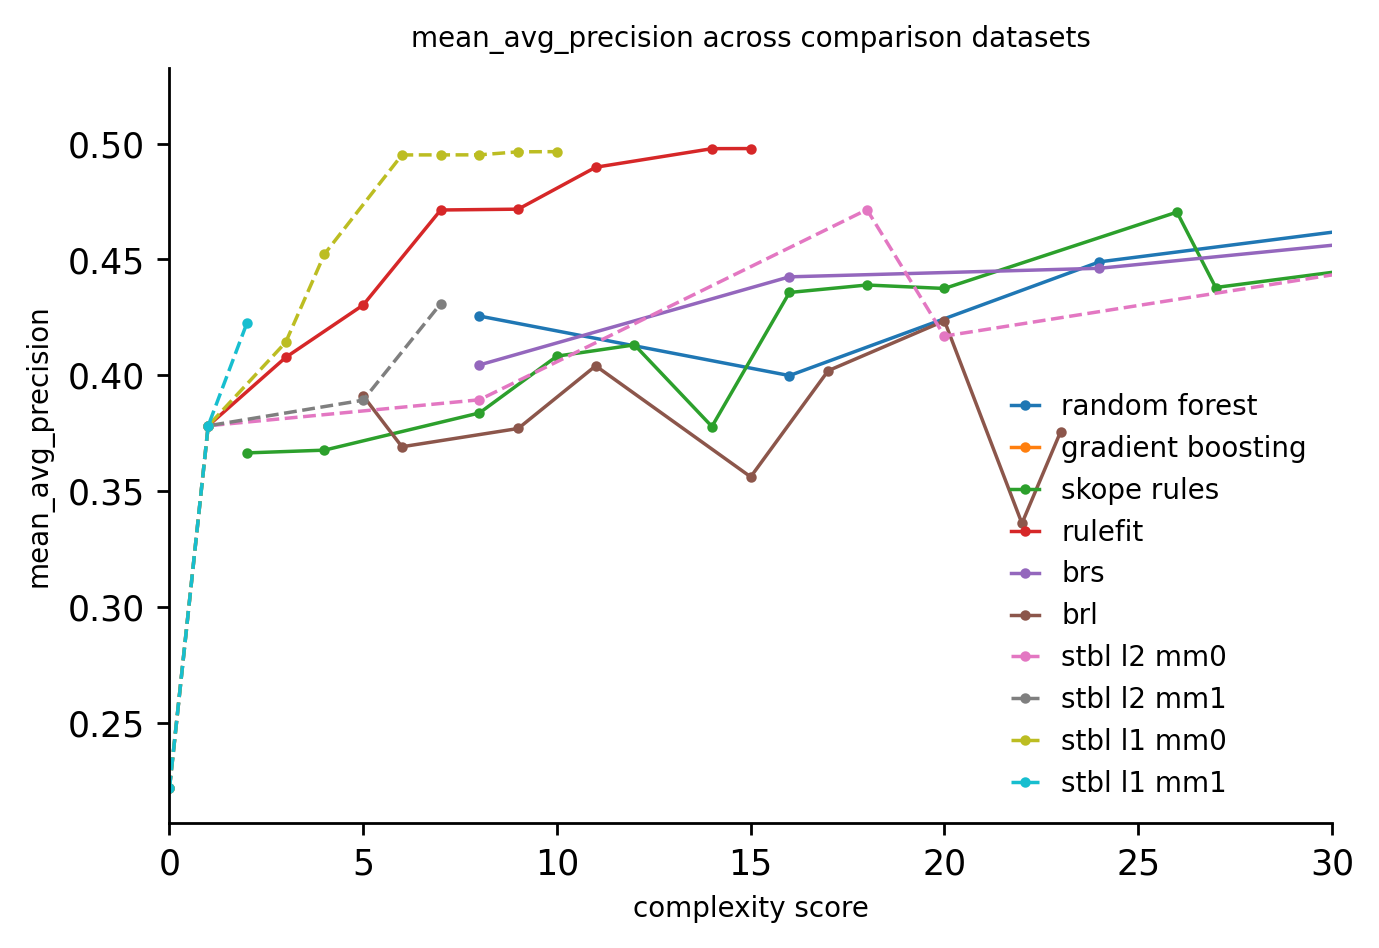

In [25]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## recidivism

In [26]:
metric = 'mean_avg_precision'
ensembles = [
    'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1',
    'stbl_l1_mm2'
]
test_models = baselines + ensembles 

In [27]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='recidivism',
                          prefix='test',
                          low_data=True) for mname in test_models
]

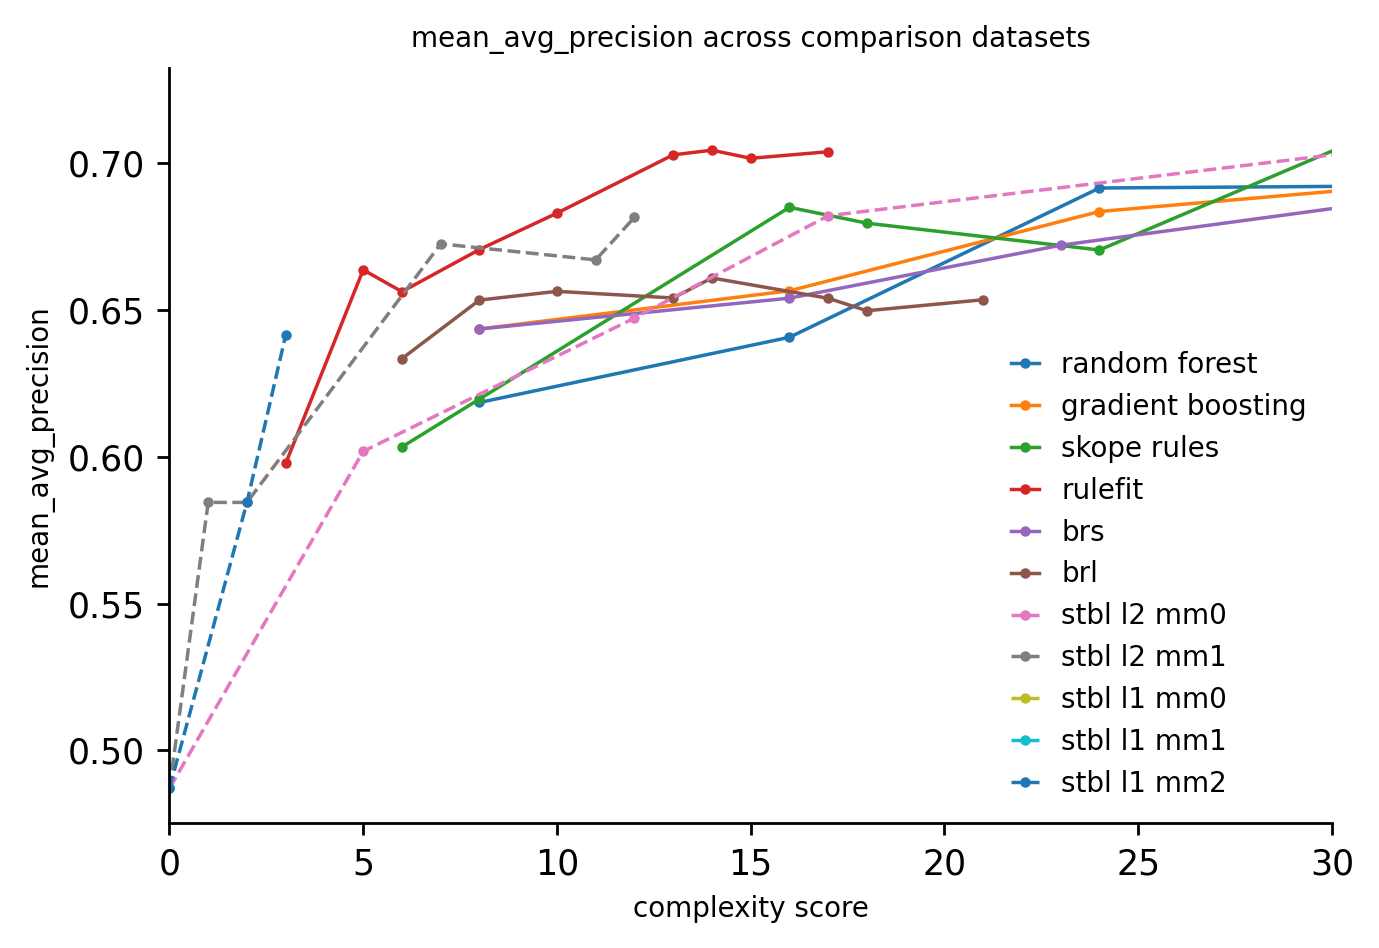

In [28]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

## juvenile

In [29]:
metric = 'mean_avg_precision'
ensembles = [
    'stbl_l2_mm0',
    'stbl_l2_mm1',
    'stbl_l1_mm0',
    'stbl_l1_mm1'
]
test_models = baselines + ensembles

In [30]:
test_results = [
    get_comparison_result(MODEL_COMPARISON_PATH, 
                          mname,
                          dataset='juvenile',
                          prefix='test',
                          low_data=True) for mname in test_models
]

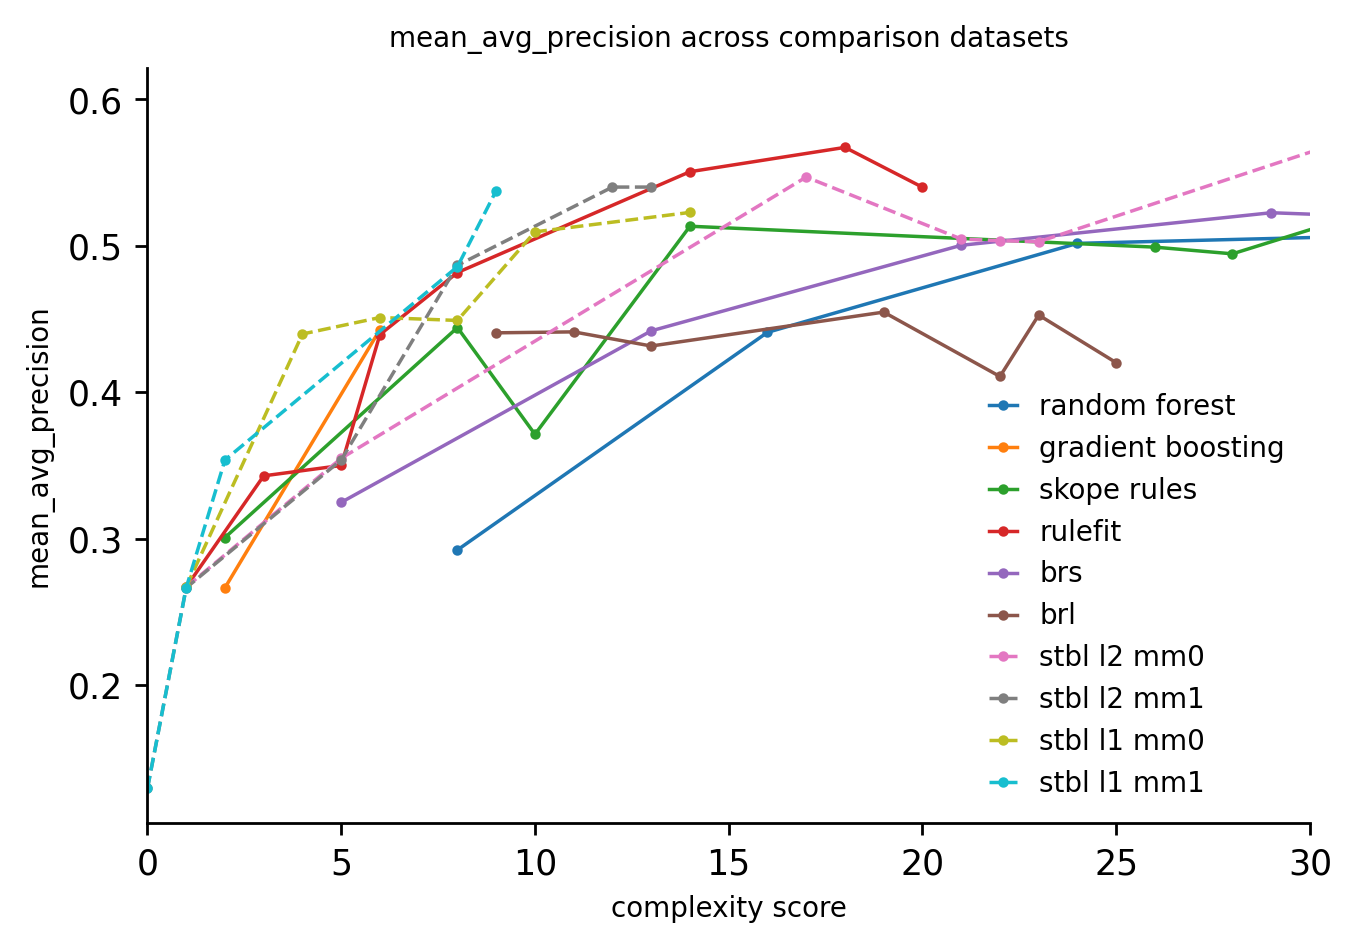

In [31]:
viz.viz_comparison_test_average(test_results, metric=metric)
plt.xlim((0, 30))
# viz.savefig(f'test_hard_{metric}.pdf')
plt.show()

In [32]:
# x, y, feat_names = get_clean_dataset('experiments/data/ICPSR_03986/DS0001/data_clean.csv')
# xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

# mlp_accs = []
# mlp_rocaucs = []
# for hidden_layer_sizes in [(200,), (200,200), (500,500)]:
#     m = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=500)
#     m.fit(xtrain, ytrain)
#     mlp_accs.append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
#     mlp_rocaucs.append(accuracy_score(ytest, m.predict(xtest)))